# Battery Pack Thermal Simulation - Realistic Scaling
This notebook is a cell-by-cell translation of the updated `trying.py` script, with all new scaling, pack architecture, and summary logic.

In [251]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import butter, filtfilt
import os
from datetime import datetime

## Configuration and Paths

In [252]:
DRIVE_CYCLE_FOLDER = "C:\\Users\\ASUS\\Documents\\reserch_code_1\\test"
CORE_CSV_PATH = "C:\\Users\\ASUS\\Documents\\reserch_code\\core.csv"
OUTPUT_PATH = "C:\\Users\\ASUS\\Documents\\reserch_code\\simulated_battery_cooling.csv"

os.makedirs("data", exist_ok=True)
os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

FORCE_REBUILD_CORE = True
ADIABATIC_MODE = False  # Set True to disable cooling

## Realistic Battery Pack Configuration

In [253]:
CELLS_IN_SERIES = 12
CELLS_IN_PARALLEL = 3
TOTAL_CELLS = CELLS_IN_SERIES * CELLS_IN_PARALLEL
NUM_ZONES = TOTAL_CELLS//3
CELL_NOMINAL_VOLTAGE = 3.7
CELL_CAPACITY = 3.0
CELL_INTERNAL_R = 0.030
CELL_HEAT_CAPACITY = 50.0
CELL_MAX_DISCHARGE_RATE = 2.0

PACK_NOMINAL_VOLTAGE = CELLS_IN_SERIES * CELL_NOMINAL_VOLTAGE
PACK_CAPACITY = CELLS_IN_PARALLEL * CELL_CAPACITY
PACK_ENERGY = PACK_NOMINAL_VOLTAGE * PACK_CAPACITY / 1000
PACK_MAX_POWER = PACK_NOMINAL_VOLTAGE * PACK_CAPACITY * CELL_MAX_DISCHARGE_RATE / 1000

print(f"🔋 BATTERY PACK SPECIFICATIONS:")
print(f"   Configuration: {CELLS_IN_SERIES}s{CELLS_IN_PARALLEL}p = {TOTAL_CELLS} cells")
print(f"   Pack voltage: {PACK_NOMINAL_VOLTAGE:.1f} V")
print(f"   Pack capacity: {PACK_CAPACITY:.1f} Ah")
print(f"   Pack energy: {PACK_ENERGY:.1f} kWh")
print(f"   Max continuous power: {PACK_MAX_POWER:.0f} kW")
print(f"   Thermal zones: {NUM_ZONES}")

🔋 BATTERY PACK SPECIFICATIONS:
   Configuration: 12s3p = 36 cells
   Pack voltage: 44.4 V
   Pack capacity: 9.0 Ah
   Pack energy: 0.4 kWh
   Max continuous power: 1 kW
   Thermal zones: 12


## Zone-Based Pack Properties with Realistic Variation

In [254]:
np.random.seed(42)
cells_per_zone = TOTAL_CELLS // NUM_ZONES
cells_in_zone = np.full(NUM_ZONES, cells_per_zone)
remainder = TOTAL_CELLS % NUM_ZONES
cells_in_zone[:remainder] += 1

cell_r_variation = np.random.normal(1.0, 0.05, NUM_ZONES)
zone_resistance = np.zeros(NUM_ZONES)
for i in range(NUM_ZONES):
    zone_resistance[i] = (CELL_INTERNAL_R * cell_r_variation[i] * CELLS_IN_SERIES) / CELLS_IN_PARALLEL
zone_heat_capacity = cells_in_zone * CELL_HEAT_CAPACITY
zone_positions = np.linspace(0, 1, NUM_ZONES)

BASE_LATERAL_CONDUCTANCE = 3.0  # W/K, realistic order of magnitude
EDGE_REDUCTION = 0.4           # edges conduct worse

lateral_conductance = BASE_LATERAL_CONDUCTANCE * (
    1.0 - EDGE_REDUCTION * np.abs(zone_positions - 0.5) * 2.0
)

print(f"📊 ZONE DISTRIBUTION:")
for i in range(NUM_ZONES):
    print(f"   Zone {i+1}: {cells_in_zone[i]} cells, {zone_resistance[i]:.4f}Ω, {zone_heat_capacity[i]:.0f}J/K")

📊 ZONE DISTRIBUTION:
   Zone 1: 3 cells, 0.1230Ω, 150J/K
   Zone 2: 3 cells, 0.1192Ω, 150J/K
   Zone 3: 3 cells, 0.1239Ω, 150J/K
   Zone 4: 3 cells, 0.1291Ω, 150J/K
   Zone 5: 3 cells, 0.1186Ω, 150J/K
   Zone 6: 3 cells, 0.1186Ω, 150J/K
   Zone 7: 3 cells, 0.1295Ω, 150J/K
   Zone 8: 3 cells, 0.1246Ω, 150J/K
   Zone 9: 3 cells, 0.1172Ω, 150J/K
   Zone 10: 3 cells, 0.1233Ω, 150J/K
   Zone 11: 3 cells, 0.1172Ω, 150J/K
   Zone 12: 3 cells, 0.1172Ω, 150J/K


## Drive Cycle Data Processing

In [255]:
# ---------- Replace entire block with this cell ----------
import os
import numpy as np
import pandas as pd

# ----------------- User-configurable controls -----------------
# If these variables already exist in your notebook they will be used.
# If not, defaults below will be applied so the cell runs standalone.
DRIVE_CYCLE_FOLDER = globals().get("DRIVE_CYCLE_FOLDER", "./drive_cycles")
CORE_CSV_PATH = globals().get("CORE_CSV_PATH", "core.csv")
FORCE_REBUILD_CORE = globals().get("FORCE_REBUILD_CORE", True)

# POWER / VEHICLE tuning
DEFAULT_VEHICLE_MASS = 2200.0  # kg, change this to tune power per speed
SCALE_TO_PACK = False          # if True, scale computed vehicle power so peak == PACK_MAX_POWER (kW)
TARGET_PEAK_KW = None          # optional override for target peak (kW). If None and SCALE_TO_PACK True uses PACK_MAX_POWER
MAX_FILES_TO_LOAD = 5         # how many .txt files to read from folder, for quick testing

# ----------------- Safety: PACK_MAX_POWER fallback -----------------
# Use existing PACK_MAX_POWER if present in notebook, else compute a fallback using typical 12s3p 18650 example
PACK_MAX_POWER = globals().get("PACK_MAX_POWER", None)
if PACK_MAX_POWER is None:
    # fallback: estimate from nominal numbers if the user hasn't defined PACK_MAX_POWER
    CELLS_IN_SERIES = globals().get("CELLS_IN_SERIES", 12)
    CELLS_IN_PARALLEL = globals().get("CELLS_IN_PARALLEL", 3)
    CELL_NOMINAL_VOLTAGE = globals().get("CELL_NOMINAL_VOLTAGE", 3.7)
    CELL_CAPACITY = globals().get("CELL_CAPACITY", 3.0)  # Ah
    CELL_MAX_DISCHARGE_RATE = globals().get("CELL_MAX_DISCHARGE_RATE", 2.0)  # C
    PACK_NOMINAL_VOLTAGE = CELLS_IN_SERIES * CELL_NOMINAL_VOLTAGE
    PACK_CAPACITY = CELLS_IN_PARALLEL * CELL_CAPACITY
    PACK_MAX_POWER = PACK_NOMINAL_VOLTAGE * PACK_CAPACITY * CELL_MAX_DISCHARGE_RATE / 1000.0  # kW
    print(f"⚠ PACK_MAX_POWER not found, using fallback estimate {PACK_MAX_POWER:.2f} kW")
else:
    PACK_MAX_POWER = PACK_MAX_POWER  # use existing

# ----------------- Drive cycle loader -----------------
def load_drive_cycle_files(folder_path, max_files=MAX_FILES_TO_LOAD):
    """
    Load up to max_files text drive cycle files from folder_path.
    Expected format: two columns (Time, Speed). The loader is tolerant to common encodings and small formatting issues.
    Returns a concatenated DataFrame with columns: Time (int seconds), Speed (float; same units as file).
    """
    print("🔄 Loading drive cycle data...")
    if not os.path.isdir(folder_path):
        raise RuntimeError(f"Drive cycle folder not found: {folder_path}")

    txt_files = sorted([f for f in os.listdir(folder_path) if f.lower().endswith(".txt")])
    if not txt_files:
        raise RuntimeError(f"No .txt files found in {folder_path}")

    dfs = []
    for file in txt_files[:max_files]:
        file_path = os.path.join(folder_path, file)
        df = None
        # Try a few encodings and separators for robustness
        for encoding in ("utf-8", "ISO-8859-1", "utf-16"):
            try:
                # many drive cycle txts are two-column with tab or whitespace; skip first header if present
                df_try = pd.read_csv(file_path, sep=None, engine="python", encoding=encoding, header=None, comment="#")
                # keep only first two columns
                if df_try.shape[1] >= 2:
                    df_try = df_try.iloc[:, :2]
                    df_try.columns = ["Time", "Speed"]
                    df = df_try
                    break
            except Exception:
                continue

        if df is None:
            print(f"   ⚠ Skipped {file}, could not parse with common encodings")
            continue

        # coerce numeric and drop bad rows
        df["Time"] = pd.to_numeric(df["Time"], errors="coerce")
        df["Speed"] = pd.to_numeric(df["Speed"], errors="coerce")
        df = df.dropna(subset=["Time", "Speed"]).copy()
        if df.empty:
            print(f"   ⚠ {file} contained no valid numeric rows after cleanup")
            continue

        # enforce integer seconds and 1 decimal for speed (keeps your formatting)
        df["Time"] = df["Time"].round().astype(int)
        df["Speed"] = df["Speed"].round(1)

        df["File"] = file
        dfs.append(df.reset_index(drop=True))
        print(f"   ✅ {file}: {len(df)} rows")

    if not dfs:
        raise RuntimeError("No valid drive cycle data loaded from folder")

    combined = pd.concat(dfs, ignore_index=True)
    # sort by Time to be safe, and drop duplicate timestamps (keep first)
    combined = combined.sort_values("Time").drop_duplicates(subset="Time").reset_index(drop=True)
    return combined

# ----------------- Vehicle power model -----------------
def calculate_realistic_ev_power(drive_df):
    VEHICLE_MASS = 2200.0
    DRAG_COEFF = 0.24
    FRONTAL_AREA = 2.34
    ROLLING_RESISTANCE = 0.008
    AIR_DENSITY = 1.225
    DRIVETRAIN_EFF = 0.92
    REGEN_EFF = 0.6

    df = drive_df.copy()
    df["Speed"] = pd.to_numeric(df["Speed"], errors="coerce").fillna(0.0)

    # speed units
    if df["Speed"].max() > 200:
        speed_mps = df["Speed"].values * (1000.0 / 3600.0)
    else:
        speed_mps = df["Speed"].values * 0.44704

    # time step
    dt = 1.0
    if "Time" in df.columns and len(df) > 1:
        dt = max(1.0, np.median(np.diff(df["Time"].values)))

    # mild smoothing only for acceleration
    speed_s = pd.Series(speed_mps).ewm(alpha=0.25).mean().values
    accel = np.zeros_like(speed_s)
    accel[1:] = (speed_s[1:] - speed_s[:-1]) / dt

    # forces
    F_aero = 0.5 * AIR_DENSITY * DRAG_COEFF * FRONTAL_AREA * speed_s**2
    F_roll = VEHICLE_MASS * 9.81 * ROLLING_RESISTANCE
    F_inertia = VEHICLE_MASS * accel
    F_total = F_aero + F_roll + F_inertia

    # vehicle mechanical power
    P_mech = F_total * speed_s
    P_mech[P_mech >= 0] /= DRIVETRAIN_EFF
    P_mech[P_mech < 0] *= REGEN_EFF

    # convert to battery current
    pack_voltage = PACK_NOMINAL_VOLTAGE
    pack_current = P_mech / pack_voltage

    # per branch current
    branch_current = pack_current / CELLS_IN_PARALLEL

    # C rate limits from Cell 1
    I_max_discharge = CELL_MAX_DISCHARGE_RATE * CELL_CAPACITY
    I_max_charge = 0.5 * CELL_CAPACITY

    branch_current = np.clip(
        branch_current,
        -I_max_charge,
        I_max_discharge
    )

    # back to pack current and power
    pack_current_limited = branch_current * CELLS_IN_PARALLEL
    power_w = pack_current_limited * pack_voltage

    power_w[power_w < 0] = 0.0
    power_w[speed_s < 0.5] = 0.0

    df["Power_W"] = power_w
    return df
# ----------------- Pipeline: load, compute, save -----------------
try:
    if not os.path.exists(DRIVE_CYCLE_FOLDER):
        raise FileNotFoundError(f"Drive cycle folder does not exist: {DRIVE_CYCLE_FOLDER}")

    if not os.path.exists(CORE_CSV_PATH) or FORCE_REBUILD_CORE:
        drive_df = load_drive_cycle_files(DRIVE_CYCLE_FOLDER, max_files=MAX_FILES_TO_LOAD)
        # compute vehicle power
        drive_df = calculate_realistic_ev_power(drive_df)

        # optionally scale to pack capability. Do not scale by default to keep dynamics visible.
        if SCALE_TO_PACK:
            target_kw = TARGET_PEAK_KW if TARGET_PEAK_KW is not None else PACK_MAX_POWER
            peak_w = max(drive_df["Power_W"].max(), 1.0)
            scale_factor = (target_kw * 1000.0) / peak_w
            drive_df["Power_W"] = drive_df["Power_W"] * scale_factor
            print(f"ℹ Scaled vehicle power so peak equals {target_kw:.3f} kW, scale factor {scale_factor:.3f}")

        drive_df["CumulativeTime"] = np.arange(len(drive_df))
        drive_df.to_csv(CORE_CSV_PATH, index=False)
        print(f"✅ Saved core dataset: {len(drive_df)} rows")
    else:
        drive_df = pd.read_csv(CORE_CSV_PATH)
        drive_df["Power_W"] = pd.to_numeric(drive_df.get("Power_W", 0.0), errors="coerce").fillna(0.0)
        print(f"📄 Loaded existing dataset: {len(drive_df)} rows")

    # stats
    time_array = np.arange(len(drive_df))
    power_profile = drive_df["Power_W"].values

    print("📈 POWER PROFILE STATS:")
    print(f"   Duration: {len(time_array)} seconds ({len(time_array)/3600:.2f} hours)")
    print(f"   Power range: {np.min(power_profile):.0f} - {np.max(power_profile):.0f} W")
    print(f"   Average power: {np.mean(power_profile):.0f} W")
    print(f"   Peak vs pack max: {np.max(power_profile)/1000.0:.2f} kW / {PACK_MAX_POWER:.1f} kW")
    if hasattr(drive_df, "attrs") and "unit_detection" in drive_df.attrs:
        print(f"   Unit heuristic: {drive_df.attrs['unit_detection']}, dt ~ {drive_df.attrs['dt_seconds']} s, vehicle mass used {drive_df.attrs['vehicle_mass_used']} kg")

except Exception as e:
    # Provide a clear, actionable error message
    raise RuntimeError(f"Drive cycle pipeline failed: {e}")
# -----------------------------------------------------------------


🔄 Loading drive cycle data...
   ✅ us06col.txt: 601 rows
✅ Saved core dataset: 601 rows
📈 POWER PROFILE STATS:
   Duration: 601 seconds (0.17 hours)
   Power range: 0 - 799 W
   Average power: 577 W
   Peak vs pack max: 0.80 kW / 0.8 kW


## Cooling System Configuration

In [256]:
if not ADIABATIC_MODE:
    MAX_PUMP_FLOW_LPM = max(20.0, PACK_MAX_POWER * 0.8)
    target_cooling_power = PACK_MAX_POWER * 800
    target_delta_t = 15.0
    total_UA = target_cooling_power / target_delta_t
    zone_UA_base = np.zeros(NUM_ZONES)
    for i in range(NUM_ZONES):
        zone_UA_base[i] = total_UA * (cells_in_zone[i] / TOTAL_CELLS)
    FLOW_ENHANCEMENT = 1.5
    PUMP_MAX_POWER_W = max(200.0, PACK_MAX_POWER * 2)
else:
    MAX_PUMP_FLOW_LPM = 0.0
    zone_UA_base = np.zeros(NUM_ZONES)
    FLOW_ENHANCEMENT = 0.0
    PUMP_MAX_POWER_W = 0.0
COOLANT_TEMP = 25.0
INITIAL_TEMP = 25.0
print(f"🌊 COOLING SYSTEM:")
print(f"   Mode: {'ADIABATIC' if ADIABATIC_MODE else 'ACTIVE COOLING'}")
if not ADIABATIC_MODE:
    print(f"   Max pump flow: {MAX_PUMP_FLOW_LPM:.1f} L/min")
    print(f"   Total heat transfer capacity: {np.sum(zone_UA_base):.0f} W/K")
    print(f"   Max pump power: {PUMP_MAX_POWER_W:.0f} W")

🌊 COOLING SYSTEM:
   Mode: ACTIVE COOLING
   Max pump flow: 20.0 L/min
   Total heat transfer capacity: 43 W/K
   Max pump power: 200 W


## PID Controller for Cooling

In [257]:
class PIDController:
    def __init__(self, Kp=3.0, Ki=0.05, Kd=0.5, setpoint=35.0, output_limits=(0.0, 1.0)):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.setpoint = setpoint
        self.output_limits = output_limits
        self.integral = 0.0
        self.prev_error = 0.0
    def reset(self):
        self.integral = 0.0
        self.prev_error = 0.0
    def update(self, measurement, dt=1.0):
        error = self.setpoint - measurement
        self.integral += error * dt
        max_integral = (self.output_limits[1] - self.output_limits[0]) / self.Ki if self.Ki > 0 else 1000
        self.integral = np.clip(self.integral, -max_integral, max_integral)
        derivative = (error - self.prev_error) / dt if dt > 0 else 0.0
        output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
        output = np.clip(output, *self.output_limits)
        self.prev_error = error
        return output
TEMP_SETPOINT = 40.0
pid_controllers = [PIDController(setpoint=TEMP_SETPOINT) for _ in range(NUM_ZONES)]

## Battery Thermal Dynamics ODE System

In [258]:
def battery_thermal_ode(t, state, power_profile, params):
    temperatures = state[:NUM_ZONES]
    coolant_flows = state[NUM_ZONES:]

    time_idx = min(int(t), len(power_profile) - 1)
    power_demand = power_profile[time_idx]

    # --------- Electrical current ---------
    pack_current = power_demand / PACK_NOMINAL_VOLTAGE

    # --------- Heat generation per zone ---------
    heat_generation = np.zeros(NUM_ZONES)
    for i in range(NUM_ZONES):
        heat_generation[i] = (pack_current ** 2) * params['zone_resistance'][i]

    # >>> FIX 1: energy preserving normalization <<<
    total_heat = np.sum(heat_generation)
    if total_heat > 0:
        heat_generation = heat_generation * (total_heat / np.sum(heat_generation))

    dT_dt = np.zeros(NUM_ZONES)
    dF_dt = np.zeros(NUM_ZONES)

    for i in range(NUM_ZONES):
        T_i = temperatures[i]
        Q_generation = heat_generation[i]

        # --------- Lateral conduction ---------
        Q_lateral = 0.0
        if i > 0:
            Q_lateral += params['lateral_conductance'][i] * (temperatures[i-1] - T_i)
        if i < NUM_ZONES - 1:
            Q_lateral += params['lateral_conductance'][i] * (temperatures[i+1] - T_i)

        # --------- Cooling ---------
        Q_cooling = 0.0
        if not ADIABATIC_MODE and coolant_flows[i] > 0:
            flow_factor = 1.0 + FLOW_ENHANCEMENT * coolant_flows[i]

            # >>> FIX 2: spatial cooling bias <<<
            zone_bias = 0.8 + 0.4 * (i / (NUM_ZONES - 1))

            UA_effective = params['zone_UA_base'][i] * flow_factor * zone_bias
            Q_cooling = UA_effective * (T_i - COOLANT_TEMP)

        # --------- Net heat balance ---------
        Q_net = Q_generation + Q_lateral - Q_cooling
        dT_dt[i] = Q_net / params['zone_heat_capacity'][i]

    # --------- Coolant dynamics ---------
    FLOW_TIME_CONSTANT = 3.0
    for i in range(NUM_ZONES):
        if not ADIABATIC_MODE:
            pid_output = params['pid_controllers'][i].update(temperatures[i], dt=1.0)
            target_flow = pid_output
        else:
            target_flow = 0.0

        dF_dt[i] = (target_flow - coolant_flows[i]) / FLOW_TIME_CONSTANT

    return np.concatenate([dT_dt, dF_dt])

## Run Thermal Simulation

In [259]:
simulation_params = {
    'zone_resistance': zone_resistance,
    'zone_heat_capacity': zone_heat_capacity,
    'zone_UA_base': zone_UA_base,
    'lateral_conductance': lateral_conductance,      # ✅ CORRECT
    'pid_controllers': pid_controllers
}
print("🚀 Running battery thermal simulation...")
initial_temperatures = np.full(NUM_ZONES, INITIAL_TEMP)
initial_flows = np.zeros(NUM_ZONES)
initial_state = np.concatenate([initial_temperatures, initial_flows])
t_span = [0, len(time_array) - 1]
t_eval = time_array
solution = solve_ivp(
    fun=lambda t, y: battery_thermal_ode(t, y, power_profile, simulation_params),
    t_span=t_span,
    y0=initial_state,
    t_eval=t_eval,
    method='RK45',
    rtol=1e-6,
    atol=1e-8
)
if not solution.success:
    print(f"❌ Simulation failed: {solution.message}")
    raise RuntimeError("ODE integration failed")
print("✅ Simulation completed successfully!")
temperatures = solution.y[:NUM_ZONES, :].T
coolant_flows = solution.y[NUM_ZONES:, :].T
print(f"📊 Results shape: {temperatures.shape} temperatures, {coolant_flows.shape} flows")

🚀 Running battery thermal simulation...
✅ Simulation completed successfully!
📊 Results shape: (601, 12) temperatures, (601, 12) flows


## Post-processing and Pump Power Calculation

In [260]:
pump_power = np.zeros(len(time_array))
total_flow_rate = np.zeros(len(time_array))
for t in range(len(time_array)):
    if not ADIABATIC_MODE:
        total_flow_lpm = np.sum(coolant_flows[t, :]) * MAX_PUMP_FLOW_LPM / NUM_ZONES
        total_flow_rate[t] = total_flow_lpm
        flow_fraction = total_flow_lpm / MAX_PUMP_FLOW_LPM if MAX_PUMP_FLOW_LPM > 0 else 0
        pump_power[t] = PUMP_MAX_POWER_W * (flow_fraction ** 2)
    else:
        pump_power[t] = 0.0
        total_flow_rate[t] = 0.0
temp_stats = {
    'initial': np.mean(temperatures[0, :]),
    'final': np.mean(temperatures[-1, :]),
    'max': np.max(temperatures),
    'min': np.min(temperatures),
    'final_spread': np.max(temperatures[-1, :]) - np.min(temperatures[-1, :])
}
energy_stats = {
    'battery_total_kwh': np.sum(power_profile) / 3600 / 1000,
    'battery_peak_kw': np.max(power_profile) / 1000,
    'pump_total_wh': np.sum(pump_power) / 3600,
    'pump_peak_w': np.max(pump_power)
}

## Visualization

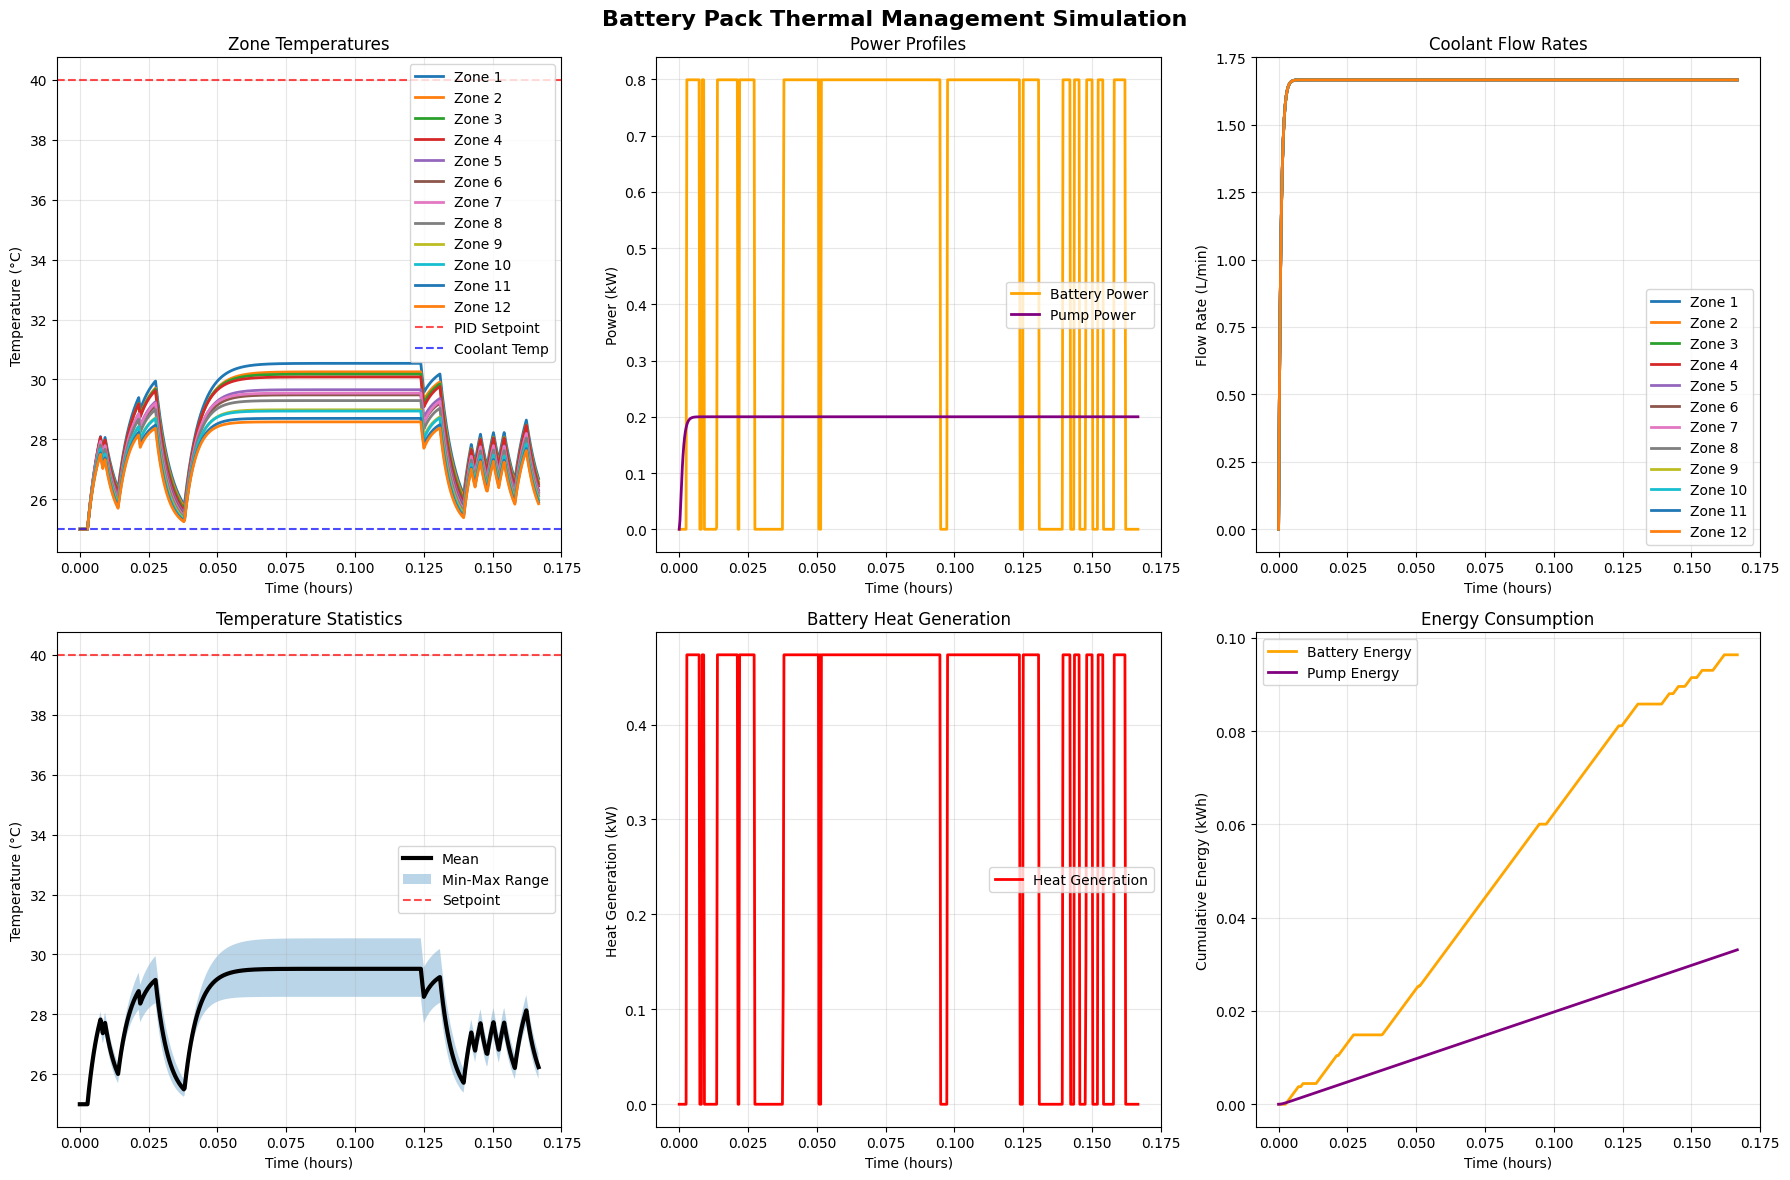

In [261]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Battery Pack Thermal Management Simulation', fontsize=16, fontweight='bold')

# Temperature profiles
ax1 = axes[0, 0]
for i in range(NUM_ZONES):
    ax1.plot(time_array/3600, temperatures[:, i], label=f'Zone {i+1}', linewidth=2)
ax1.axhline(y=TEMP_SETPOINT, color='r', linestyle='--', alpha=0.7, label='PID Setpoint')
ax1.axhline(y=COOLANT_TEMP, color='b', linestyle='--', alpha=0.7, label='Coolant Temp')
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Temperature (°C)')
ax1.set_title('Zone Temperatures')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Power profiles
ax2 = axes[0, 1]
ax2.plot(time_array/3600, power_profile/1000, color='orange', label='Battery Power', linewidth=2)
if not ADIABATIC_MODE:
    ax2.plot(time_array/3600, pump_power/1000, color='purple', label='Pump Power', linewidth=2)
ax2.set_xlabel('Time (hours)')
ax2.set_ylabel('Power (kW)')
ax2.set_title('Power Profiles')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Coolant flows
ax3 = axes[0, 2]
if not ADIABATIC_MODE:
    for i in range(NUM_ZONES):
        flow_lpm = coolant_flows[:, i] * MAX_PUMP_FLOW_LPM / NUM_ZONES
        ax3.plot(time_array/3600, flow_lpm, label=f'Zone {i+1}', linewidth=2)
    ax3.set_xlabel('Time (hours)')
    ax3.set_ylabel('Flow Rate (L/min)')
    ax3.set_title('Coolant Flow Rates')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'ADIABATIC MODE\n(No Cooling)', 
             ha='center', va='center', transform=ax3.transAxes, fontsize=14)
    ax3.set_title('Coolant Flow (Disabled)')

# Temperature statistics
ax4 = axes[1, 0]
temp_mean = np.mean(temperatures, axis=1)
temp_max = np.max(temperatures, axis=1)
temp_min = np.min(temperatures, axis=1)
ax4.plot(time_array/3600, temp_mean, 'k-', label='Mean', linewidth=3)
ax4.fill_between(time_array/3600, temp_min, temp_max, alpha=0.3, label='Min-Max Range')
ax4.axhline(y=TEMP_SETPOINT, color='r', linestyle='--', alpha=0.7, label='Setpoint')
ax4.set_xlabel('Time (hours)')
ax4.set_ylabel('Temperature (°C)')
ax4.set_title('Temperature Statistics')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Heat generation
ax5 = axes[1, 1]
pack_current = power_profile / PACK_NOMINAL_VOLTAGE
total_heat = np.zeros(len(time_array))
for i in range(NUM_ZONES):
    zone_heat = (pack_current ** 2) * zone_resistance[i]
    total_heat += zone_heat
ax5.plot(time_array/3600, total_heat/1000, color='red', label='Heat Generation', linewidth=2)
ax5.set_xlabel('Time (hours)')
ax5.set_ylabel('Heat Generation (kW)')
ax5.set_title('Battery Heat Generation')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Energy balance
ax6 = axes[1, 2]
cumulative_battery = np.cumsum(power_profile) / 3600 / 1000  # kWh
cumulative_pump = np.cumsum(pump_power) / 3600 / 1000  # kWh
ax6.plot(time_array/3600, cumulative_battery, color='orange', label='Battery Energy', linewidth=2)
if not ADIABATIC_MODE:
    ax6.plot(time_array/3600, cumulative_pump, color='purple', label='Pump Energy', linewidth=2)
ax6.set_xlabel('Time (hours)')
ax6.set_ylabel('Cumulative Energy (kWh)')
ax6.set_title('Energy Consumption')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Save Results

In [262]:
results_df = pd.DataFrame({
    'Time_s': time_array,
    'Time_h': time_array / 3600,
    'Battery_Power_W': power_profile,
    'Pump_Power_W': pump_power,
    'Total_Flow_LPM': total_flow_rate,
    'Pack_Current_A': power_profile / PACK_NOMINAL_VOLTAGE,
})
for i in range(NUM_ZONES):
    results_df[f'Zone_{i+1}_Temp_C'] = temperatures[:, i]
for i in range(NUM_ZONES):
    results_df[f'Zone_{i+1}_Flow_LPM'] = coolant_flows[:, i] * MAX_PUMP_FLOW_LPM / NUM_ZONES
results_df['Mean_Temp_C'] = np.mean(temperatures, axis=1)
results_df['Max_Temp_C'] = np.max(temperatures, axis=1)
results_df['Min_Temp_C'] = np.min(temperatures, axis=1)
results_df['Temp_Spread_K'] = results_df['Max_Temp_C'] - results_df['Min_Temp_C']
results_df.to_csv(OUTPUT_PATH, index=False)
print(f"💾 Results saved to: {OUTPUT_PATH}")

💾 Results saved to: C:\Users\ASUS\Documents\reserch_code\simulated_battery_cooling.csv


## Performance Summary

In [263]:
print("\n" + "="*60)
print("🎯 BATTERY PACK THERMAL SIMULATION SUMMARY")
print("="*60)
print(f"📦 PACK CONFIGURATION:")
print(f"   Architecture: {CELLS_IN_SERIES}s{CELLS_IN_PARALLEL}p ({TOTAL_CELLS} cells)")
print(f"   Energy capacity: {PACK_ENERGY:.1f} kWh")
print(f"   Max power: {PACK_MAX_POWER:.0f} kW")
print(f"   Thermal zones: {NUM_ZONES}")
print(f"\n⏱️ SIMULATION:")
print(f"   Duration: {len(time_array)/3600:.1f} hours ({len(time_array)} seconds)")
print(f"   Mode: {'Adiabatic (no cooling)' if ADIABATIC_MODE else 'Active liquid cooling'}")
print(f"\n🌡️ THERMAL PERFORMANCE:")
print(f"   Initial temperature: {temp_stats['initial']:.1f}°C")
print(f"   Final average temperature: {temp_stats['final']:.1f}°C")
print(f"   Maximum temperature: {temp_stats['max']:.1f}°C")
print(f"   Temperature rise: {temp_stats['max'] - temp_stats['initial']:.1f}°C")
print(f"   Final zone spread: {temp_stats['final_spread']:.1f}°C")
print(f"\n⚡ ENERGY ANALYSIS:")
print(f"   Battery energy delivered: {energy_stats['battery_total_kwh']:.2f} kWh")
print(f"   Peak battery power: {energy_stats['battery_peak_kw']:.1f} kW")
print(f"   Battery utilization: {energy_stats['battery_peak_kw']/PACK_MAX_POWER:.1%} of max")
if not ADIABATIC_MODE:
    print(f"   Pump energy consumed: {energy_stats['pump_total_wh']:.1f} Wh")
    print(f"   Peak pump power: {energy_stats['pump_peak_w']:.1f} W")
    print(f"   Cooling overhead: {energy_stats['pump_total_wh']/1000/energy_stats['battery_total_kwh']:.2%}")
    if temp_stats['max'] < 50:
        print(f"   Cooling status: ✅ EFFECTIVE")
    elif temp_stats['max'] < 60:
        print(f"   Cooling status: ⚠️ MARGINAL")
    else:
        print(f"   Cooling status: ❌ INSUFFICIENT")
print("="*60)
print("🎉 Simulation completed successfully!")


🎯 BATTERY PACK THERMAL SIMULATION SUMMARY
📦 PACK CONFIGURATION:
   Architecture: 12s3p (36 cells)
   Energy capacity: 0.4 kWh
   Max power: 1 kW
   Thermal zones: 12

⏱️ SIMULATION:
   Duration: 0.2 hours (601 seconds)
   Mode: Active liquid cooling

🌡️ THERMAL PERFORMANCE:
   Initial temperature: 25.0°C
   Final average temperature: 26.2°C
   Maximum temperature: 30.5°C
   Temperature rise: 5.5°C
   Final zone spread: 0.8°C

⚡ ENERGY ANALYSIS:
   Battery energy delivered: 0.10 kWh
   Peak battery power: 0.8 kW
   Battery utilization: 100.0% of max
   Pump energy consumed: 33.1 Wh
   Peak pump power: 200.0 W
   Cooling overhead: 34.36%
   Cooling status: ✅ EFFECTIVE
🎉 Simulation completed successfully!
